In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

,state,account_length,area_code,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn
0,OH,107,area_code_415,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,no
1,NJ,137,area_code_415,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,no
2,OH,84,area_code_408,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,no
3,OK,75,area_code_415,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,no
4,MA,121,area_code_510,no,yes,24,218.2,88,37.09,348.5,108,29.62,212.6,118,9.57,7.5,7,2.03,3,no


Looks like 4 columns have high variance and would possibly benefit some kind of normalization

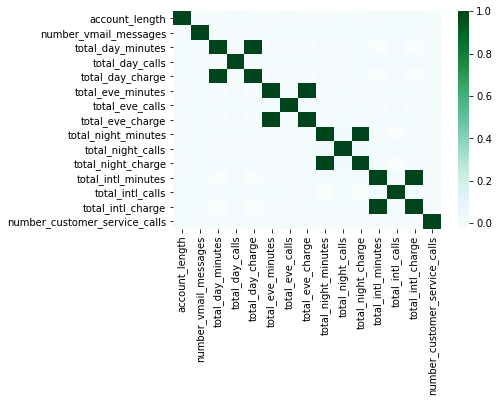

In [4]:
sns.heatmap(df.corr(),cmap='BuGn');

Looks like there is multicollinearity among certain numerical features, hence some need be dropped

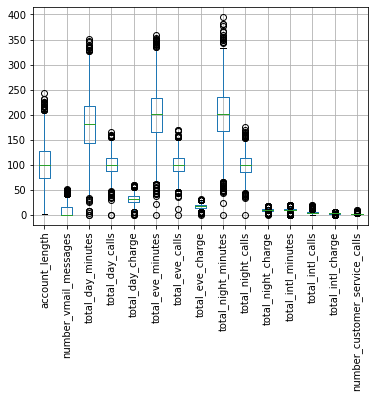

In [5]:
df[df.select_dtypes(['int64','float64']).columns].boxplot()
plt.xticks(rotation=90);

The boxplot overview suggests that, since some outliers are in, the options are either proceed with the removal or adopt a robust scaling

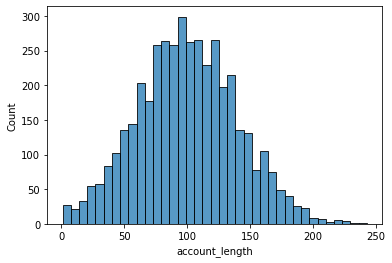

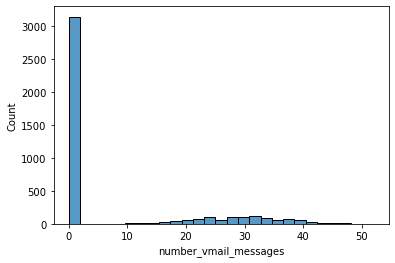

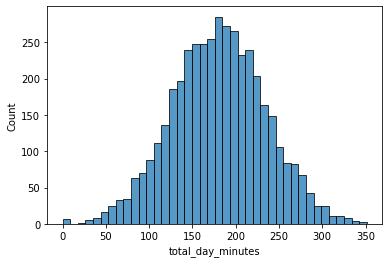

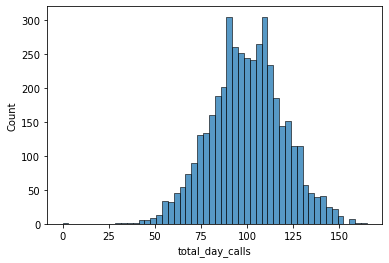

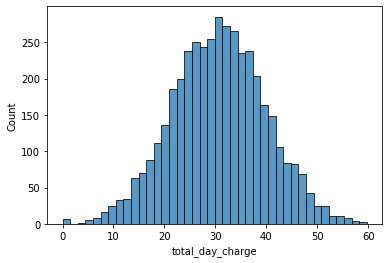

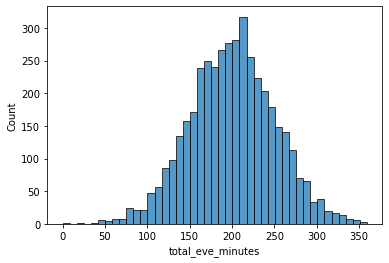

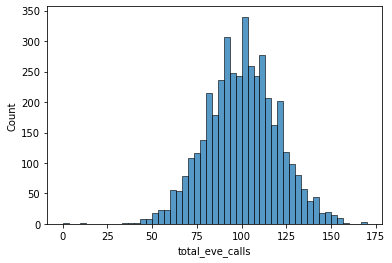

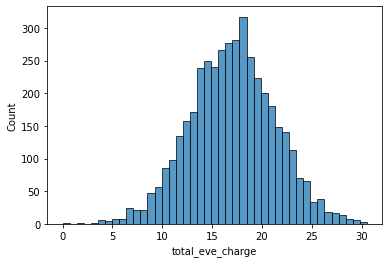

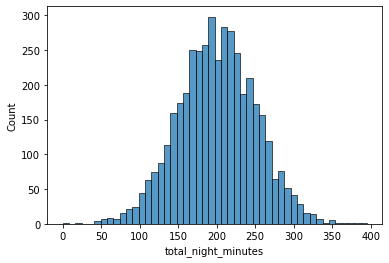

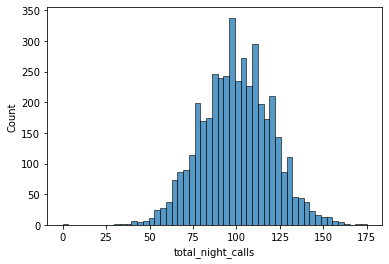

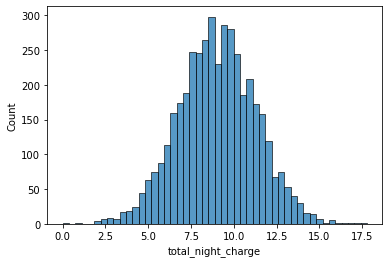

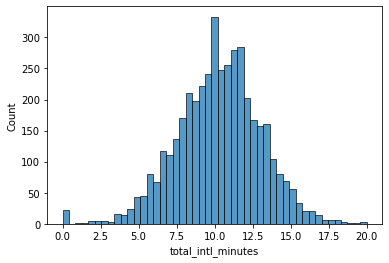

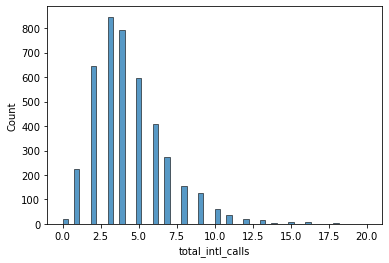

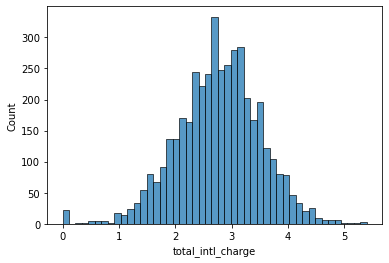

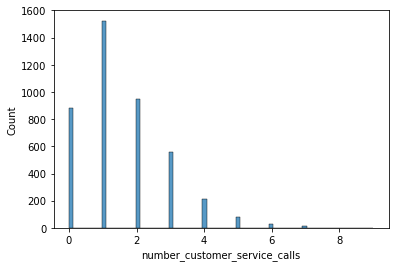

In [6]:
for i in df.select_dtypes(['int64','float64']).columns:
    sns.histplot(df[i]);
    plt.show();

The majority of numerical features shows a gaussian distribution

In [7]:
df.select_dtypes('object').head()

,state,area_code,international_plan,voice_mail_plan,churn
0,OH,area_code_415,no,yes,no
1,NJ,area_code_415,no,no,no
2,OH,area_code_408,yes,no,no
3,OK,area_code_415,yes,no,no
4,MA,area_code_510,no,yes,no


We have some categorical columns: we need to encode them

In [8]:
df.churn.value_counts(normalize=True)

no     0.859294
yes    0.140706
Name: churn, dtype: float64

The df is unbalanced and needs oversampling/undersampling

I will proceed with building some pipelines that include preprocessing, feature selection and model training in order to evaluate which performs best. To do so, I will use, along with standard classes, some custom classes to be imported from the file func.py

Importing libraries

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from func import PearsonSelector, MinMaxScalerCust, StandardScalerCust, BinaryEncoder, GetDummies, DropColumns, get_best, plot_roc_prc, get_results
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, f_classif, RFE
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve

Let's split the df into train and test

In [10]:
X = df.drop('churn', axis=1)
y = df.churn.map({'yes':1,'no':0})                                                    #not encodable in the pipeline
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=8)

Defining pipelines along with relative parameters to be used in GridSearchCV

#### Pipe 1 ---> StandardScaler + PCA

In [11]:
pipe_1 = make_pipeline(PearsonSelector(),\
                       #OutliersIQR(),\
                       StandardScalerCust(),\
                       BinaryEncoder(selected_columns = ['international_plan','voice_mail_plan']),\
                       DropColumns(['state','area_code']),\
                       #GetDummies(),
                       SMOTE(),\
                       PCA(),\
                       xgb.XGBClassifier(n_jobs=-1))

params_1 = [{'pearsonselector__limit': [0.2,0.4],
          'smote__k_neighbors': [3,5],
          'pca__n_components': [2,3],
          'xgbclassifier__n_estimators': [1000]}]


#### Pipe 2 ---> MinMaxScaler + RFE

In [12]:
pipe_2 = make_pipeline(PearsonSelector(),\
                       #OutliersIQR(),\
                       MinMaxScalerCust(),\
                       BinaryEncoder(selected_columns = ['international_plan','voice_mail_plan']),\
                       DropColumns(['state','area_code']),\
                       #GetDummies(),
                       SMOTE(),\
                       RFE(LogisticRegression(max_iter=500)),\
                       xgb.XGBClassifier(n_jobs=-1))

params_2 = [{'pearsonselector__limit': [0.2,0.4],
          'smote__k_neighbors': [5,7],
          'rfe__n_features_to_select': [0.3,0.5] ,
          'xgbclassifier__n_estimators': [1000]}]

#### Pipe 3 ---> MinMaxScaler + SelectKBest

In [13]:
pipe_3 = make_pipeline(PearsonSelector(),\
                       #OutliersIQR(),\
                       MinMaxScalerCust(),\
                       BinaryEncoder(selected_columns = ['international_plan','voice_mail_plan']),\
                       DropColumns(['state','area_code']),\
                       #GetDummies(),
                       SMOTE(),\
                       SelectKBest(),\
                       xgb.XGBClassifier(n_jobs=-1))

params_3 = [{'pearsonselector__limit': [0.2,0.4],
          'smote__k_neighbors': [5],
          'selectkbest__score_func': [chi2, f_classif],\
          'selectkbest__k': [2,5,10],\
          'xgbclassifier__n_estimators': [1000]}]

Defining a dictionary that keeps pipelines and parameters defined above

In [14]:
pipe_dict = {'pipe_1': [pipe_1, params_1],
             'pipe_2': [pipe_2, params_2],
             'pipe_3': [pipe_3, params_3]}

Fitting the pipes and collecting best estimators for each pipe in a dictionary

In [ ]:
best_estimators = get_best(pipe_dict, X_train, X_test, y_train)

Let's print out the results

In [18]:
get_results(best_estimators, X_test, y_test).T

,AUC,Precision,Recall,F1
pipe_1,0.831759,0.378261,0.737288,0.500000
pipe_2,0.911550,0.625850,0.779661,0.694340
pipe_3,0.954710,0.867257,0.830508,0.848485


Looks like pipe_3 (i.e. MinMaxScaler + SelectKBest) performed the best according to all the considered metrics

For a visual clue, let's plot roc and prc

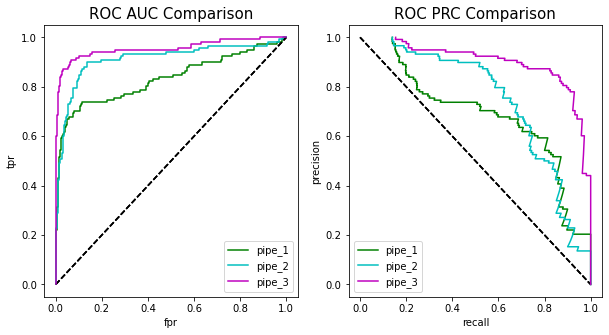

In [22]:
plot_roc_prc(best_estimators, X_test, y_test)

### Conclusion

Pipe_3 assures a better precision/recall tradeoff, which is a good indicator for a model which has to predict customers that churn